# Programming Historian Stylometry

In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import packages
import nltk
import math

## Assign papers to author and load papers

In [3]:
# assing papers to authors
papers = {
    'Madison': [10, 14, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
    'Hamilton': [1, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 21, 22, 23, 24, 
                 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 59, 60,
                 61, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 
                 78, 79, 80, 81, 82, 83, 84, 85],
    'Jay': [2, 3, 4, 5],
    'Shared': [18, 19, 20],
    'Disputed': [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63],
    'TestCase': [64]
}

In [4]:
# A function that compiles all of the text files associated with a single author into a single string
def read_files_into_string(filenames):
    strings = []
    for filename in filenames:
        with open(f'data/federalist_{filename}.txt') as f:
            strings.append(f.read())
    return '\n'.join(strings)

In [5]:
# Make a dictionary out of the authors' corpora
federalist_by_author = {}  
for author, files in papers.items():
    federalist_by_author[author] = read_files_into_string(files)

In [6]:
for author in papers:
    print(federalist_by_author[author][:100])

 10

The Same Subject Continued (The Union as a Safeguard Against Domestic
Faction and Insurrection)
 1

General Introduction

For the Independent Journal. Saturday, October 27, 1787


HAMILTON

To the
 2

Concerning Dangers from Foreign Force and Influence

For the Independent Journal. Wednesday, Oct
 18

The Same Subject Continued (The Insufficiency of the Present
Confederation to Preserve the Unio
 49

Method of Guarding Against the Encroachments of Any One Department of
Government by Appealing t
 64

The Powers of the Senate

From The Independent Journal. Wednesday, March 5, 1788.

JAY

To the 


## Mendenhall’s Characteristic Curves of Composition

In [7]:
# Compare the disputed papers to those written by everyone, including the shared ones. 
authors = ("Hamilton", "Madison", "Disputed", "Jay", "Shared")

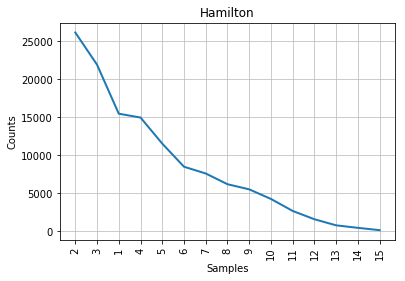

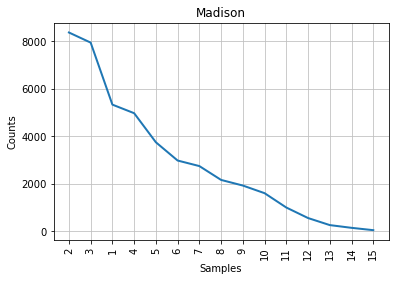

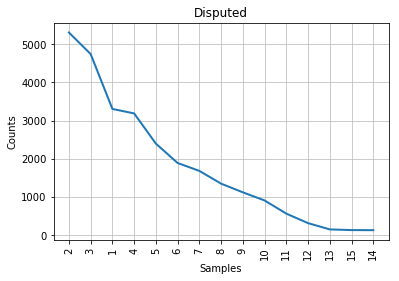

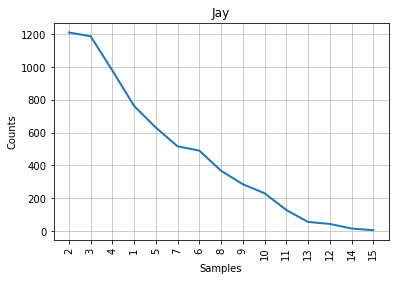

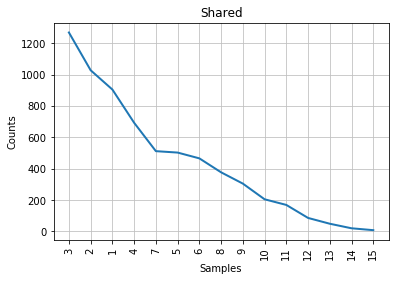

In [8]:
# Transform the authors' corpora into lists of word tokens
federalist_by_author_tokens = {}
federalist_by_author_length_distributions = {}
for author in authors:
    tokens = nltk.word_tokenize(federalist_by_author[author])
    
    # Filter out punctuation
    federalist_by_author_tokens[author] = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
   
    # Get a distribution of token lengths
    token_lengths = [len(token) for token in federalist_by_author_tokens[author]]
    federalist_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)
    federalist_by_author_length_distributions[author].plot(15,title=author)      

## Kilgariff’s Chi-Squared Method

In [9]:
# Who are the authors we are analyzing?
authors = ("Hamilton", "Madison")

In [10]:
# Lowercase the tokens so that the same word, capitalized or not, 
# counts as one word
for author in authors:
    federalist_by_author_tokens[author] = (
        [token.lower() for token in federalist_by_author_tokens[author]])

In [11]:
federalist_by_author_tokens["Disputed"] = ([token.lower() for token in federalist_by_author_tokens["Disputed"]])

In [12]:
# Calculate chisquared for each of the two candidate authors
for author in authors:
   
    # First, build a joint corpus and identify the 500 most frequent words in it
    joint_corpus = (federalist_by_author_tokens[author] + 
                    federalist_by_author_tokens["Disputed"])
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # What proportion of the joint corpus is made up 
    # of the candidate author's tokens?
    author_share = (len(federalist_by_author_tokens[author]) 
                    / len(joint_corpus))
    
    # Now, let's look at the 500 most common words in the candidate 
    # author's corpus and compare the number of times they can be observed 
    # to what would be expected if the author's papers 
    # and the Disputed papers were both random samples from the same distribution.
    chisquared = 0
    for word,joint_count in most_common:
        
        # How often do we really see this common word?
        author_count = federalist_by_author_tokens[author].count(word)
        disputed_count = federalist_by_author_tokens["Disputed"].count(word)
        
        # How often should we see it?
        expected_author_count = joint_count * author_share
        expected_disputed_count = joint_count * (1-author_share)
        
        # Add the word's contribution to the chi-squared statistic
        chisquared += ((author_count-expected_author_count) * 
                       (author_count-expected_author_count) / 
                       expected_author_count)
                    
        chisquared += ((disputed_count-expected_disputed_count) *
                       (disputed_count-expected_disputed_count) 
                       / expected_disputed_count)
        
    print("The Chi-squared statistic for candidate", author, "is", chisquared)

The Chi-squared statistic for candidate Hamilton is 3479.618660463175
The Chi-squared statistic for candidate Madison is 1946.450032425074


## John Burrows’ Delta Method 

In [13]:
# Who are we dealing with this time?
authors = ("Hamilton", "Madison", "Jay", "Disputed", "Shared")

In [14]:
# Combine every paper except our test case into a single corpus
whole_corpus = []
for author in authors:
    whole_corpus += federalist_by_author_tokens[author]

In [15]:
# Get a frequency distribution
whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
whole_corpus_freq_dist[ :10 ]

[('the', 17745),
 (',', 13262),
 ('of', 11795),
 ('to', 6999),
 ('.', 5461),
 ('and', 5012),
 ('in', 4383),
 ('a', 3957),
 ('be', 3770),
 ('that', 2739)]

In [16]:
# Initialize main data structure
features = [word for word,freq in whole_corpus_freq_dist]
feature_freqs = {}

In [17]:
# Calculate features for each author (subcorpus)
for author in authors:
    # A dictionary for each candidate's features
    feature_freqs[author] = {} 
    
    # A helper value containing the number of tokens in the author's subcorpus
    overall = len(federalist_by_author_tokens[author])
    
    # Calculate each feature's presence in the subcorpus
    for feature in features:
        presence = federalist_by_author_tokens[author].count(feature)
        feature_freqs[author][feature] = presence / overall

In [18]:
# Data structure for storing the "corpus standard" statistics
corpus_features = {}

In [19]:
# Calculate mean and standard deviation for each feature
for feature in features:
    # Create a sub-dictionary that will contain the feature's mean 
    # and standard deviation
    corpus_features[feature] = {}
    
    # Calculate the mean of the frequencies expressed in the subcorpora
    feature_average = 0
    for author in authors:
        feature_average += feature_freqs[author][feature]
    feature_average /= len(authors)
    corpus_features[feature]["Mean"] = feature_average
    
    # Calculate the standard deviation using the basic formula for a sample
    feature_stdev = 0
    for author in authors:
        diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
        feature_stdev += diff*diff
    feature_stdev /= (len(authors) - 1)
    feature_stdev = math.sqrt(feature_stdev)
    corpus_features[feature]["StdDev"] = feature_stdev

#### Calculating z-scores

In [20]:
feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:
        
        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) / feature_stdev)

In [21]:
# Tokenize the test case
testcase_tokens = nltk.word_tokenize(federalist_by_author["TestCase"])
    
# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens 
                   if any(c.isalpha() for c in token)]
 
# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall
    
# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

Test case z-score for feature the is -0.5650346393997929
Test case z-score for feature , is 1.8631345411530462
Test case z-score for feature of is -1.7868886729353024
Test case z-score for feature to is 1.0693802768125718
Test case z-score for feature . is -1.032037948131366
Test case z-score for feature and is 1.084314203046851
Test case z-score for feature in is 0.7487344633854833
Test case z-score for feature a is -0.769632333357852
Test case z-score for feature be is 1.0263486324052553
Test case z-score for feature that is 1.9302482249860562
Test case z-score for feature it is 0.2247912999207539
Test case z-score for feature is is -0.8522937873005267
Test case z-score for feature which is -2.017201717639158
Test case z-score for feature by is 1.2991385048009638
Test case z-score for feature as is 4.434415826158143
Test case z-score for feature ; is -0.4044584559287325
Test case z-score for feature this is -0.6277502914623035
Test case z-score for feature not is 0.8408128847740354
T

#### Calculating delta

In [22]:
for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] - 
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )

Delta score for candidate Hamilton is 1.7788224320379045
Delta score for candidate Madison is 1.5285050337964883
Delta score for candidate Jay is 1.4101402278922635
Delta score for candidate Disputed is 1.531810011359639
Delta score for candidate Shared is 1.9660297142091139
